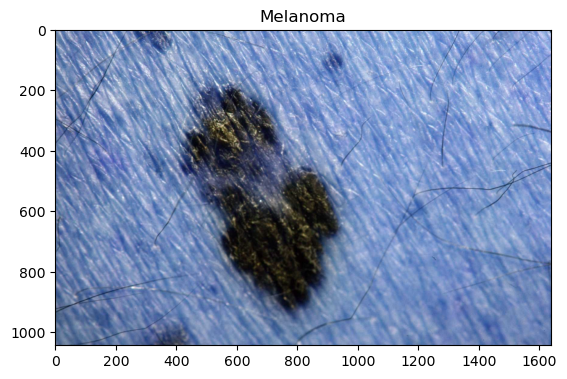

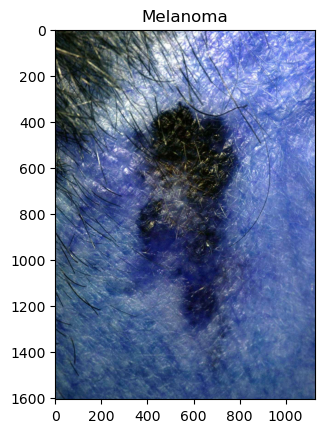

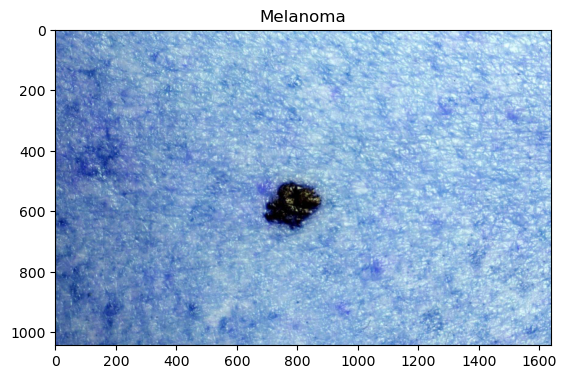

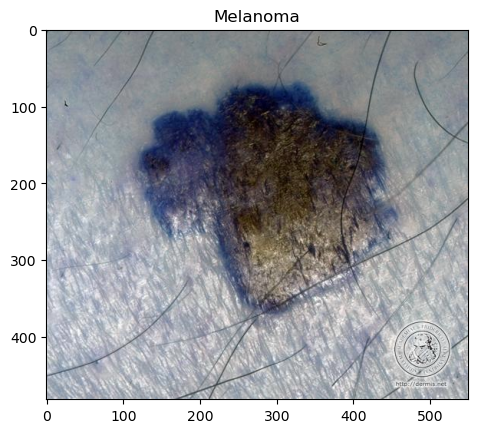

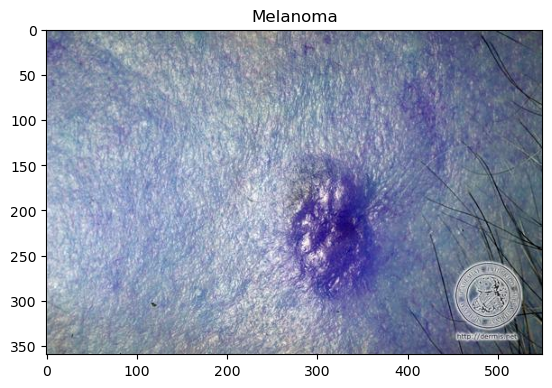

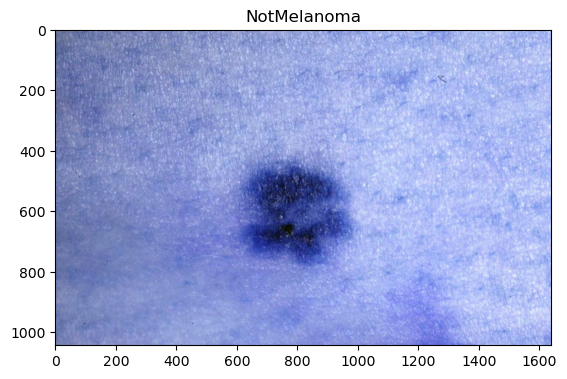

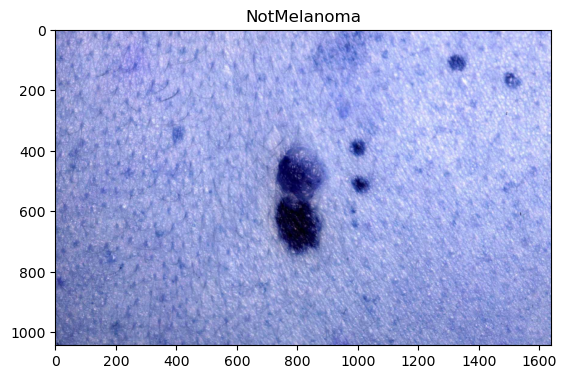

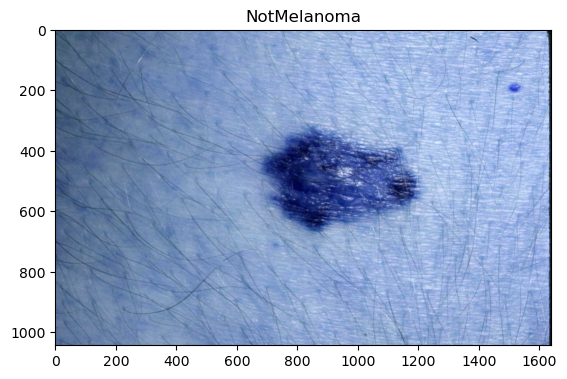

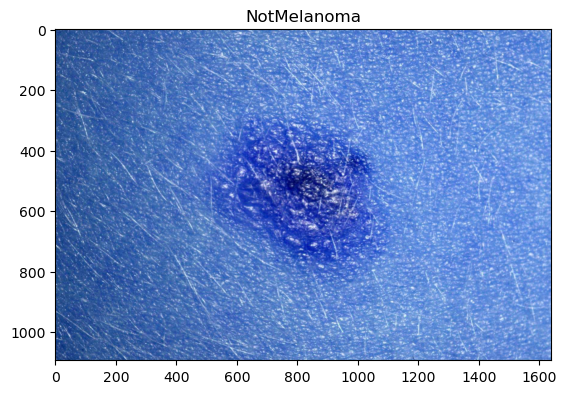

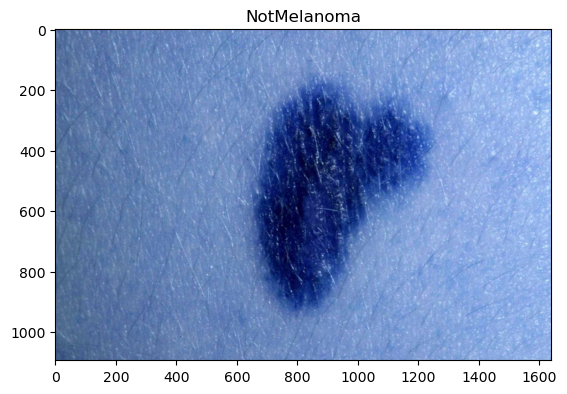

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore")

DATADIR = r"/Users/san5h0llow/Data_Science/Skin_deases/Dataset/"
CATEGORIES = ["Melanoma","NotMelanoma"]

for i in CATEGORIES:
    path = os.path.join(DATADIR,i)
    j=0
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path,img))
        plt.imshow(img)
        plt.title(("Melanoma" if i == "Melanoma" else "NotMelanoma"))
        plt.show()
        j+=1
        if j == 5:
            break

In [2]:
IMG_SIZE = 128
training_data = []

def create_training_data():
    for i in CATEGORIES:
        path = os.path.join(DATADIR,i)
        class_num = CATEGORIES.index(i)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [3]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0
X = X.reshape(-1,128,128,1)

(180, 128, 128)


In [4]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes = 2)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,y,test_size = 0.2, random_state=42,shuffle=True)

In [6]:
print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

X_train shape (144, 128, 128, 1)
X_test shape (36, 128, 128, 1)
y_train shape (144, 2)
y_test shape (36, 2)


In [7]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Sequential
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [8]:
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)
    flatten = Flatten()(conv10)
    dense1 = Dense(256, activation="relu")(flatten)
    dense2 = Dense(128, activation="relu")(dense1)
    dense3 = Dense(2, activation="sigmoid")(dense2)
    return Model(inputs=[inputs], outputs=[dense3])

In [9]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= "categorical_crossentropy", metrics= ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

                                                                                                  
 activation_10 (Activation)  (None, 16, 16, 512)          0         ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)          (None, 16, 16, 512)          2359808   ['activation_10[0][0]']       
                                                                                                  
 batch_normalization_5 (Bat  (None, 16, 16, 512)          2048      ['conv2d_11[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_11 (Activation)  (None, 16, 16, 512)          0         ['batch_normalization_5[0][0]'
                                                                    ]                             
          

In [10]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, verbose=0)

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[6.3175435066223145, 0.8394474983215332, 0.7336544990539551, 0.5858973264694214, 0.6228473782539368, 0.5544916391372681, 0.5747665762901306, 0.5882483124732971, 0.6749101281166077, 0.6406353712081909, 0.6034700274467468, 0.47382768988609314, 0.5101690888404846, 0.5196474194526672, 0.443832129240036, 0.452649861574173, 0.41534075140953064, 0.42360201478004456, 0.3946554958820343, 0.3591632544994354, 0.3664590120315552, 0.3652716875076294, 0.33837687969207764, 0.31829050183296204, 0.31834474205970764, 0.31029900908470154, 0.3054511547088623, 0.27897655963897705, 0.27090391516685486, 0.27084290981292725, 0.3252895474433899, 0.2533688545227051, 0.22730006277561188, 0.2579975426197052, 0.22752372920513153, 0.2840086817741394, 0.22851379215717316, 0.248464897274971, 0.18241152167320251, 0.1840371936559677, 0.17455658316612244, 0.16049116849899292, 0.14796613156795502, 0.15391960740089417, 0.15264815092086792, 0.1459141969680786, 0.12226203829050064, 0.17871253192424774, 0.16266880929470062, 

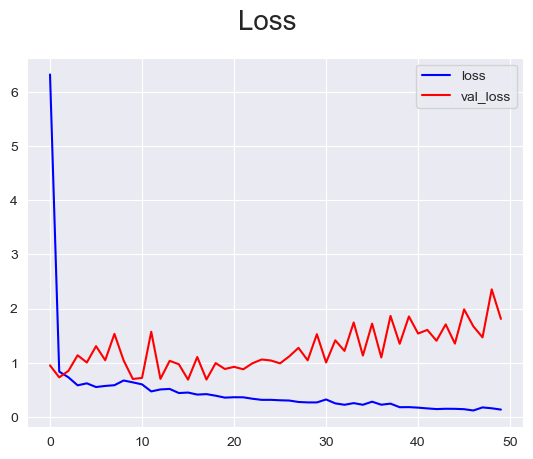

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

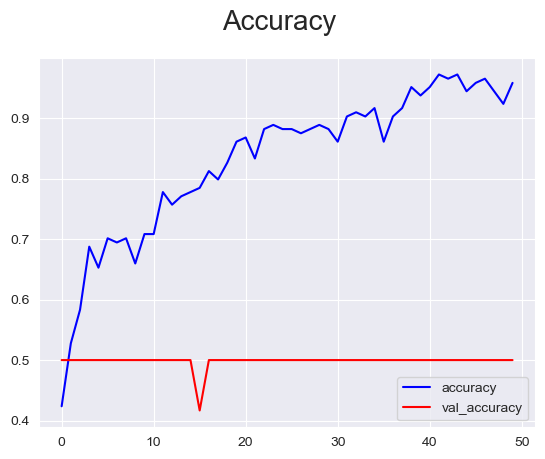

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()